In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve
from scipy import stats

Data prep

In [10]:
df = pd.read_csv("our data/Art1.csv")
df.head()

,Time:128Hz,Epoch,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Event Id,Event Date,Event Duration
0,0.000000,0,4168.974121,4152.436035,4161.025879,4124.358887,4158.205078,4162.948730,4162.436035,4163.205078,4168.589844,4166.666504,4225.897461,4172.051270,4192.948730,4170.897461,NaN,NaN,NaN
1,0.007812,0,4171.794922,4157.436035,4163.974121,4132.948730,4156.666504,4164.102539,4159.358887,4164.743652,4163.205078,4167.563965,4217.307617,4167.948730,4186.025879,4173.077148,NaN,NaN,NaN
2,0.015625,0,4174.487305,4159.743652,4168.589844,4139.615234,4159.615234,4161.666504,4161.794922,4166.794922,4160.128418,4167.051270,4220.000000,4166.794922,4184.743652,4170.769043,NaN,NaN,NaN
3,0.023438,0,4161.410156,4153.589844,4161.282227,4134.871582,4161.666504,4162.563965,4164.358887,4164.743652,4160.641113,4165.769043,4209.871582,4155.769043,4179.230957,4161.153809,NaN,NaN,NaN
4,0.031250,1,4147.563965,4148.333496,4156.282227,4136.794922,4161.794922,4163.333496,4162.436035,4162.307617,4166.538574,4165.128418,4197.948730,4147.179688,4173.589844,4151.153809,NaN,NaN,NaN


In [14]:
# Define input and output directories
input_folder = "our data"  # Replace with the path to your source folder
output_folder = "ourdata_prepared"  # Replace with the path to your target folder

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Processing parameters
sampling_rate = 128  # 128 Hz timescale
cut_time_seconds = 4.5  # Time to cut in seconds
rows_to_cut = int(sampling_rate * cut_time_seconds)  # Number of rows to cut

# Loop through all CSV files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Process only CSV files
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Read the CSV file
        df = pd.read_csv(input_path)

        # Cut the first 4.5 seconds (first `rows_to_cut` rows)
        df = df.iloc[rows_to_cut:]
        
        # Drop the first 2 columns
        df = df.iloc[:, 2:]

        # Drop the last 3 columns
        df = df.iloc[:, :-3]

        # Save the processed file to the output folder
        df.to_csv(output_path, index=False)

        print(f"Processed and saved: {filename}")

print("All files processed successfully!")


Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

Testy Shapiro-Wilka dla sprawdzenia czy mamy do czynienia z rozkładem normalnym:

In [17]:
input_folder = "ourdata_prepared"  # Replace with the folder path

# Loop through all the EEG data files
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Initialize counter for columns passing Shapiro-Wilk test
        normal_count = 0
        total_columns = len(df.columns)

        # Loop through each channel (column) in the dataframe
        for col in df.columns:
            # Perform Shapiro-Wilk test for normality
            stat, p_value = stats.shapiro(df[col])

            if p_value >= 0.05:
                normal_count += 1  # Column follows normal distribution

        # Print the result for the file
        print(f"{filename} - {normal_count}/{total_columns} columns follow normal distribution")

Art1.csv - 3/14 columns follow normal distribution
Art10.csv - 3/14 columns follow normal distribution
Art11.csv - 3/14 columns follow normal distribution
Art12.csv - 0/14 columns follow normal distribution
Art13.csv - 1/14 columns follow normal distribution
Art14.csv - 2/14 columns follow normal distribution
Art15.csv - 0/14 columns follow normal distribution
Art16.csv - 2/14 columns follow normal distribution
Art17.csv - 2/14 columns follow normal distribution
Art18.csv - 3/14 columns follow normal distribution
Art19.csv - 2/14 columns follow normal distribution
Art2.csv - 3/14 columns follow normal distribution
Art20.csv - 1/14 columns follow normal distribution
Art21.csv - 3/14 columns follow normal distribution
Art22.csv - 2/14 columns follow normal distribution
Art23.csv - 2/14 columns follow normal distribution
Art24.csv - 3/14 columns follow normal distribution
Art25.csv - 1/14 columns follow normal distribution
Art26.csv - 2/14 columns follow normal distribution
Art27.csv - 3/

Niewielka ilość danych posiada rozkład normalny, tak więc zastosujemy inną metodę normalizacji niż standaryzacja Z. Zastosowaliśmy algorytm RobustScaler

In [9]:
from sklearn.preprocessing import RobustScaler
input_folder = "ourdata_prepared"
output_folder = "ourdata_scaled"
# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Apply Robust Scaling
        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        
        output_filepath = os.path.join(output_folder, filename)
        df_scaled.to_csv(output_filepath, index=False)
        print(f"Processed and saved: {filename}")      

Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

In [10]:
df = pd.read_csv("ourdata_scaled/Art1.csv")
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.680217,-0.247278,-1.194151,-0.206928,-0.323513,-1.090893,0.044844,-0.391290,0.391290,0.407475,-0.846396,-0.394776,-0.533710,-0.368726
1,-0.607901,-0.326989,-1.110648,-0.226733,-0.470595,-1.227320,0.314591,-0.391290,0.260970,1.185049,-0.591461,-0.265255,-0.453481,-0.404328
2,-0.802246,-0.345107,-1.269305,-0.193074,-0.529405,0.545533,0.224561,0.434675,-0.913065,0.407475,-0.792858,-0.349936,-0.520334,-0.465353
3,-1.123148,-0.341485,-1.423796,-0.123765,0.264703,1.045533,0.808900,1.347740,0.217420,-0.222144,-1.086039,-0.603988,-0.660728,-0.620477
4,-1.145750,-0.397641,-1.519830,-0.141586,0.176543,-0.863747,-0.404450,0.086935,0.565160,0.851763,-0.978971,-0.696144,-0.669640,-0.727283


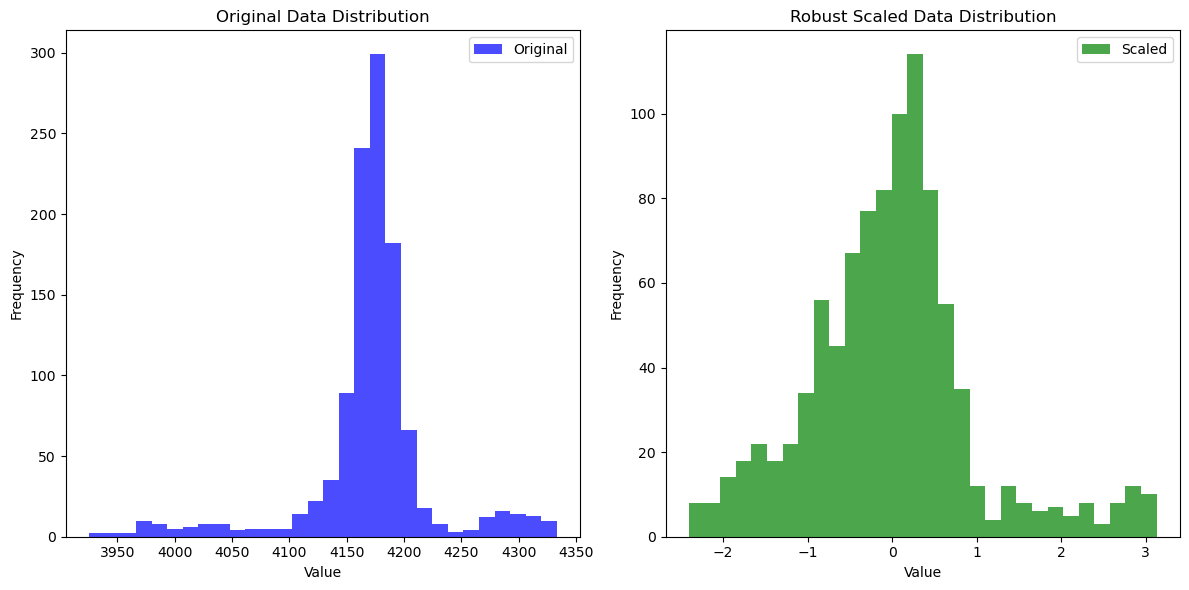

In [5]:
# Plot histograms for a sample column before and after scaling
column_original = df.iloc[:, 0]
column_scaled = df_scaled.iloc[:, 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(column_original, bins=30, alpha=0.7, color='blue', label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(column_scaled, bins=30, alpha=0.7, color='green', label='Scaled')
plt.title("Robust Scaled Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

Jak widać na wykresie zmieniła się zarówno dystrybucja danych, jak i same wartości zostały odpowiednio przeskalowane

In [12]:
df_scaled.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.514754,0.012160,-1.821489,-0.187530,0.095221,-0.439976,1.214227,1.639756,1.388619,-0.968817,-0.027175,-0.131904,-0.113055,0.001370
1,-0.499692,0.014595,-1.839777,-0.296142,-0.047610,-0.280012,-0.214363,0.759939,-0.333192,-0.687574,-0.058229,-0.194556,-0.092632,-0.099862
2,-0.371630,0.087544,-1.832621,-0.279169,0.261903,-0.560024,-0.214363,1.039756,-1.221917,-0.593787,-0.073759,-0.224233,-0.010942,0.036934
3,-0.323918,0.087544,-1.821091,-0.280869,0.190532,-1.519957,-1.500000,-0.520030,-0.666596,-0.937515,-0.002330,-0.156633,0.091176,0.190153
4,-0.399248,0.017022,-1.817911,-0.291049,0.428584,-0.560024,-1.071409,-0.919878,0.222128,0.218757,0.000775,-0.097278,0.110139,0.119015


Here’s how the class is structured:

Feature Extractor:

A CNN extracts spatial features from EEG channels.
An RNN processes sequential (temporal) features for variable-length input.
Similarity Metric:

The outputs from the feature extractors for both inputs are compared using a distance metric (e.g., Euclidean or cosine similarity).

In [15]:
class SiameseEEGNet(nn.Module):
    def __init__(self, input_channels):
        """
        Siamese Neural Network for EEG data.
        :param input_channels: Number of EEG channels (e.g., 14 if your EEG has 14 channels)
        """
        super(SiameseEEGNet, self).__init__()
        
        # Feature extractor network
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Downsample by 2
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling to make the output length-agnostic
        )
        
        # Fully connected layers for embedding
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Final embedding size
        )
    
    def forward_one_branch(self, x):
        """
        Forward pass for one branch of the Siamese network.
        :param x: Input EEG data (batch_size, input_channels, time_steps)
        :return: Embedding vector (batch_size, 32)
        """
        features = self.feature_extractor(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten for fully connected layer
        embedding = self.fc(features)  # Generate embedding
        return embedding
    
    def forward(self, x1, x2):
        """
        Forward pass for the Siamese network.
        :param x1: EEG data for branch 1 (batch_size, input_channels, time_steps)
        :param x2: EEG data for branch 2 (batch_size, input_channels, time_steps)
        :return: Embeddings for both inputs
        """
        embedding1 = self.forward_one_branch(x1)
        embedding2 = self.forward_one_branch(x2)
        return embedding1, embedding2

# Example usage
# input_channels = 14 for EEG data with 14 channels
model = SiameseEEGNet(input_channels=14)

Taki model uczymy w specyficzny sposób: Dostarczamy danych treningowych od osoby właściwej, a także dane niewłaściwe od innych oraz udające osobę właściwą inne osoby.

Loss function for this network

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        """
        Contrastive Loss
        :param embedding1: Embedding from branch 1
        :param embedding2: Embedding from branch 2
        :param label: 1 if same class, 0 if different class
        :return: Loss value
        """
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

Key Loss Function: Contrastive Loss
The contrastive loss is widely used in Siamese networks. It ensures that:

The embeddings of similar pairs are closer in the embedding space.
The embeddings of dissimilar pairs are farther apart, with a margin to encourage separation.

Initialization:

At the start, embeddings are randomly distributed in the feature space.

Forward Pass:

For a given pair of inputs, the network computes embeddings

𝑒1 and 𝑒2.

The Euclidean distance  𝐷 is calculated.
The contrastive loss measures how well the embeddings reflect the similarity/dissimilarity of the pair.

Backward Pass:

Gradients of the loss with respect to the network parameters are computed.
For similar pairs (𝑦=1):
The network adjusts weights to reduce 𝐷.
For dissimilar pairs (y=0):

If

𝐷 < 𝑚, the network adjusts weights to increase 𝐷.

If

𝐷 > 𝑚, no gradient is propagated for dissimilar pairs.

Optimization:

Using an optimizer like Adam or SGD, the network updates weights to minimize the contrastive loss.

Embedding Separation:

The network learns to position embeddings of similar inputs closer and dissimilar inputs farther apart.
The embedding space becomes more structured, with distinct clusters for each class.
Improved Pairwise Distinction:

The Euclidean distance 
𝐷
 becomes a reliable metric for class similarity.
Smaller 
𝐷
 for similar pairs, and larger 
𝐷
 for dissimilar pairs.
Margin Enforcement:

For dissimilar pairs, the network ensures embeddings are separated by at least the margin 
𝑚.
Generalization:

With sufficient data and training, the network generalizes to unseen pairs, correctly predicting similarity or dissimilarity.

In [11]:
class EnhancedAutoencoder(nn.Module):
    def __init__(self, in_channels):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension (N, 32, T/2, C)
            nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 64, T/4, C)
            nn.Conv2d(64, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 128, T/8, C)
        )
        
        # Bottleneck (latent space)
        self.bottleneck = nn.Conv2d(128, 256, kernel_size=(1, 5), padding=(0, 2))  # (N, 256, T/8, C)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(32, in_channels, kernel_size=(1, 5), padding=(0, 2)),  # (N, in_channels, T, C)
            nn.Tanh()  # Tanh for output in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

Sorting the data into training and validation datasets and folders

In [20]:
import shutil
import random

def create_datasets(data_folder, output_folder):
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Create output directories for each person
    for person in people:
        # Make directories for training, validation, and testing sets
        branch1_train_dir = os.path.join(output_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(output_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(output_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(output_folder, f"{person}_validation_branch2")
        branch1_test_dir = os.path.join(output_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(output_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(output_folder, f"{person}_testing_branch_random")

        os.makedirs(branch1_train_dir, exist_ok=True)
        os.makedirs(branch2_train_dir, exist_ok=True)
        os.makedirs(branch1_val_dir, exist_ok=True)
        os.makedirs(branch2_val_dir, exist_ok=True)
        os.makedirs(branch1_test_dir, exist_ok=True)
        os.makedirs(branch2_test_dir, exist_ok=True)
        os.makedirs(branch_random_test_dir, exist_ok=True)

        # Get list of all recordings for the person (Art1-Art45, Oli1-Oli45, Tym1-Tym45)
        recordings = [f"{person}{i}" for i in range(1, 46)]  
        
        # Create a list of impostor recordings (person trying to impersonate the target person)
        impostor_recordings = []
        for other_person in people:
            if other_person != person:
                for i in range(1, 4):
                    impostor_recordings.append(f"{other_person}log-{person}{i}")
        
        # Remove non-existent files (such as Olilog-Art2 if it doesn't exist)
        impostor_recordings = [file for file in impostor_recordings if os.path.exists(os.path.join(data_folder, f"{file}.csv"))]
        
        # Shuffle the list of impostor recordings to ensure randomness
        random.shuffle(impostor_recordings)
        
        # Branch 1: Training set (randomly select 38 recordings for the person)
        branch1_train_files = random.sample(recordings, 38)  # Select 38 random recordings for training
        for file in branch1_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_train_dir, f"{file}.csv"))
        
        # Branch 2: Training set (2 impostor files + 36 random recordings from other people)
        branch2_train_files = []
        branch2_train_files.extend(impostor_recordings[:2])  # Two impostor files
        other_people_recordings = []
        
        # Collect 36 recordings from other people
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        random.shuffle(other_people_recordings)
        branch2_train_files.extend(other_people_recordings[:36])
        
        # Copy all branch2 train files
        for file in branch2_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_train_dir, f"{file}.csv"))
        
        # Validation Set for Branch 1 (7 files from remaining recordings of the person, not in training set)
        remaining_recordings = list(set(recordings) - set(branch1_train_files))  # Remaining files
        branch1_val_files = random.sample(remaining_recordings, 7)  # Select 7 random recordings from remaining files
        for file in branch1_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_val_dir, f"{file}.csv"))
        
        # Validation Set for Branch 2 (7 random recordings from other people not in training set)
        # First, collect all recordings of other people
        other_people_recordings = []
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        
        # Remove the recordings already used in training set for branch2
        other_people_recordings = list(set(other_people_recordings) - set(branch2_train_files))
        
        # Select 7 random recordings from other people for branch2 validation
        branch2_val_files = random.sample(other_people_recordings, 7)
        
        # Copy all branch2 val files
        for file in branch2_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_val_dir, f"{file}.csv"))
        
        # Test Set for Branch 1 (Test recordings like Artlog1, Olilog2, etc.)
        branch1_test_files = [f"{person}log{i}" for i in range(1, 4)]
        for file in branch1_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_test_dir, f"{file}.csv"))
        
        # Test Set for Branch 2 (3 random impostor files that have not been used in training)
        branch2_test_files = random.sample(impostor_recordings[2:], 3)  # Select 3 random impostor files not used in training
        
        # Copy all branch2 test files
        for file in branch2_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_test_dir, f"{file}.csv"))
        
        # Random Test Set (Olilog-random1, Tymlog-random2, etc.)
        branch_random_test_files = [f"{person}log-random{i}" for i in range(1, 4)]
        for file in branch_random_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch_random_test_dir, f"{file}.csv"))
        
        print(f"Dataset created for {person}")

# Example usage
data_folder = "ourdata_scaled"  # Folder containing EEG CSV files (e.g., Art1.csv, Oli32.csv)
output_folder = "user_database"  # Folder to store the new datasets

create_datasets(data_folder, output_folder)


Dataset created for Art
Dataset created for Oli
Dataset created for Tym


Sliding Window Approach
The sliding window approach is a method for breaking down time-series data (such as EEG recordings) into smaller, overlapping or non-overlapping segments of fixed size. It’s particularly useful for processing data with variable lengths, as it enables uniform input sizes for machine learning models.

Window Size:

The number of time steps in each segment.
For EEG data, the window size might correspond to a specific duration, e.g., 1 second (128 samples at 128 Hz).
Step Size (Stride):

The number of time steps the window moves forward for the next segment.
If the step size is smaller than the window size, the windows overlap. If it's equal, there's no overlap.
Overlapping vs. Non-Overlapping Windows:

Overlapping: Captures more contextual information, as segments share data points.
Non-Overlapping: Simpler, but may miss transitions or subtle patterns at window boundaries.

We will use overlapping windows (the window step is smaller than window length)

In [17]:
def apply_sliding_window(data, window_length, window_step):
    """
    Applies a sliding window to the EEG data to create overlapping windows.
    """
    windows = []
    num_samples = len(data)
    
    for start in range(0, num_samples - window_length + 1, window_step):
        end = start + window_length
        window = data[start:end]
        windows.append(window)
    
    return np.array(windows)


In [25]:
def create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=128, window_step=64):
    """
    Processes the dataset using a sliding window approach for EEG data.
    The input_folder contains subfolders for each person's training, validation, and testing data.
    """
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Iterate through each person
    for person in people:
        # Folders where the data for each person is stored
        branch1_train_dir = os.path.join(input_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(input_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(input_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(input_folder, f"{person}_validation_branch2")
        
        # Test data folders
        branch1_test_dir = os.path.join(input_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(input_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(input_folder, f"{person}_testing_branch_random")
        
        # Create output directories for storing sliding windows with -datawindow suffix
        person_window_dir = os.path.join(output_folder, f"{person}_datawindow")
        os.makedirs(person_window_dir, exist_ok=True)
        
        # Process the branch1 training files
        process_directory(branch1_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch1")
        
        # Process the branch2 training files
        process_directory(branch2_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch2")
        
        # Process the branch1 validation files
        process_directory(branch1_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch1")
        
        # Process the branch2 validation files
        process_directory(branch2_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch2")
        
        # Process the branch1 test files
        process_directory(branch1_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch1")
        
        # Process the branch2 test files
        process_directory(branch2_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch2")
        
        # Process the random test files
        process_directory(branch_random_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch_random")

        print(f"Sliding windows created for {person}")

def process_directory(input_dir, output_dir, window_length, window_step, label_prefix):
    """
    Processes the files in a directory, applying the sliding window approach and saving the windows.
    """
    # Get all files in the directory
    files = sorted(os.listdir(input_dir))
    
    for file_name in files:
        # Ensure that the file is a CSV
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_dir, file_name)
            
            # Load EEG data from the CSV file
            df = pd.read_csv(file_path)
            eeg_data = df.to_numpy()  # Convert to numpy array
            
            # Apply sliding window to create smaller chunks
            windows = apply_sliding_window(eeg_data, window_length, window_step)
            
            # Create a new directory for this file with -datawindow suffix
            file_datawindow_dir = os.path.join(output_dir, f"{label_prefix}_datawindow")
            os.makedirs(file_datawindow_dir, exist_ok=True)
            
            # Save the windows to new files with the -datawindow{i} suffix
            for i, window in enumerate(windows):
                window_filename = f"{file_name.replace('.csv', '')}_datawindow{i}.csv"
                window_file_path = os.path.join(file_datawindow_dir, window_filename)
                window_df = pd.DataFrame(window)  # Convert window to DataFrame for saving
                window_df.to_csv(window_file_path, index=False)

# Example usage
input_folder = "user_database"  # Folder containing the training/validation directories (e.g., Art_training_branch1)
output_folder = "user_database_windowed/length256_step96"  # Folder to store the new sliding window datasets

#Tniemy dane w okienka i tworzymy okienka danych o dlugosci i skoku, 128-1 sekunda
create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=256, window_step=96)

Sliding windows created for Art
Sliding windows created for Oli
Sliding windows created for Tym


Przekształciliśmy wszystkie dane w okienka danych o równej długości.

Define the model

In [13]:
in_channels = data_reshaped.shape[1]
model = EnhancedAutoencoder(in_channels=in_channels)
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=1e-4)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #gradient clipping


tensor(0.)

Training loop

Epoch 1/2000: 100%|██████████| 2/2 [00:59<00:00, 29.67s/batch, loss=0.755]


Epoch 1/2000, Average Loss: 0.7041


Epoch 2/2000: 100%|██████████| 2/2 [01:05<00:00, 32.88s/batch, loss=0.683]


Epoch 2/2000, Average Loss: 0.6714


Epoch 3/2000: 100%|██████████| 2/2 [00:57<00:00, 28.53s/batch, loss=0.914]


Epoch 3/2000, Average Loss: 0.7714


Epoch 4/2000: 100%|██████████| 2/2 [01:02<00:00, 31.31s/batch, loss=0.585]


Epoch 4/2000, Average Loss: 0.6266


Epoch 5/2000: 100%|██████████| 2/2 [01:01<00:00, 30.68s/batch, loss=0.583]


Epoch 5/2000, Average Loss: 0.6241


Epoch 6/2000: 100%|██████████| 2/2 [01:02<00:00, 31.36s/batch, loss=0.823]


Epoch 6/2000, Average Loss: 0.7275


Epoch 7/2000: 100%|██████████| 2/2 [01:03<00:00, 31.82s/batch, loss=0.667]


Epoch 7/2000, Average Loss: 0.6573


Epoch 8/2000: 100%|██████████| 2/2 [00:58<00:00, 29.19s/batch, loss=0.571]


Epoch 8/2000, Average Loss: 0.6124


Epoch 9/2000: 100%|██████████| 2/2 [00:56<00:00, 28.02s/batch, loss=0.799]


Epoch 9/2000, Average Loss: 0.7084


Epoch 10/2000: 100%|██████████| 2/2 [00:56<00:00, 28.30s/batch, loss=0.556]


Epoch 10/2000, Average Loss: 0.5969


Epoch 11/2000: 100%|██████████| 2/2 [00:56<00:00, 28.03s/batch, loss=0.693]


Epoch 11/2000, Average Loss: 0.6506


Epoch 12/2000: 100%|██████████| 2/2 [01:02<00:00, 31.25s/batch, loss=0.677]


Epoch 12/2000, Average Loss: 0.6355


Epoch 13/2000: 100%|██████████| 2/2 [01:00<00:00, 30.30s/batch, loss=0.585]


Epoch 13/2000, Average Loss: 0.5857


Epoch 14/2000: 100%|██████████| 2/2 [01:00<00:00, 30.15s/batch, loss=0.491]


Epoch 14/2000, Average Loss: 0.5339


Epoch 15/2000: 100%|██████████| 2/2 [00:58<00:00, 29.27s/batch, loss=0.476]


Epoch 15/2000, Average Loss: 0.5167


Epoch 16/2000: 100%|██████████| 2/2 [00:58<00:00, 29.45s/batch, loss=0.456]


Epoch 16/2000, Average Loss: 0.4983


Epoch 17/2000: 100%|██████████| 2/2 [01:04<00:00, 32.26s/batch, loss=0.592]


Epoch 17/2000, Average Loss: 0.5495


Epoch 18/2000: 100%|██████████| 2/2 [01:02<00:00, 31.41s/batch, loss=0.57] 


Epoch 18/2000, Average Loss: 0.5335


Epoch 19/2000: 100%|██████████| 2/2 [01:01<00:00, 30.81s/batch, loss=0.429]


Epoch 19/2000, Average Loss: 0.4658


Epoch 20/2000: 100%|██████████| 2/2 [01:02<00:00, 31.47s/batch, loss=0.503]


Epoch 20/2000, Average Loss: 0.4925


Epoch 21/2000: 100%|██████████| 2/2 [01:01<00:00, 30.92s/batch, loss=0.517]


Epoch 21/2000, Average Loss: 0.4925


Epoch 22/2000: 100%|██████████| 2/2 [01:06<00:00, 33.35s/batch, loss=0.411]


Epoch 22/2000, Average Loss: 0.4402


Epoch 23/2000: 100%|██████████| 2/2 [01:05<00:00, 32.70s/batch, loss=0.56] 


Epoch 23/2000, Average Loss: 0.5006


Epoch 24/2000: 100%|██████████| 2/2 [01:03<00:00, 31.74s/batch, loss=0.283]


Epoch 24/2000, Average Loss: 0.3752


Epoch 25/2000: 100%|██████████| 2/2 [01:02<00:00, 31.45s/batch, loss=0.514]


Epoch 25/2000, Average Loss: 0.4730


Epoch 26/2000: 100%|██████████| 2/2 [01:03<00:00, 31.73s/batch, loss=0.379]


Epoch 26/2000, Average Loss: 0.4109


Epoch 27/2000: 100%|██████████| 2/2 [00:56<00:00, 28.22s/batch, loss=0.442]


Epoch 27/2000, Average Loss: 0.4352


Epoch 28/2000: 100%|██████████| 2/2 [01:09<00:00, 34.54s/batch, loss=0.362]


Epoch 28/2000, Average Loss: 0.3974


Epoch 29/2000: 100%|██████████| 2/2 [01:13<00:00, 36.87s/batch, loss=0.525]


Epoch 29/2000, Average Loss: 0.4656


Epoch 30/2000: 100%|██████████| 2/2 [01:07<00:00, 33.79s/batch, loss=0.48] 


Epoch 30/2000, Average Loss: 0.4424


Epoch 31/2000: 100%|██████████| 2/2 [01:08<00:00, 34.38s/batch, loss=0.445]


Epoch 31/2000, Average Loss: 0.4240


Epoch 32/2000: 100%|██████████| 2/2 [01:05<00:00, 32.60s/batch, loss=0.399]


Epoch 32/2000, Average Loss: 0.4005


Epoch 33/2000: 100%|██████████| 2/2 [01:05<00:00, 32.99s/batch, loss=0.548]


Epoch 33/2000, Average Loss: 0.4623


Epoch 34/2000: 100%|██████████| 2/2 [01:04<00:00, 32.07s/batch, loss=0.505]


Epoch 34/2000, Average Loss: 0.4403


Epoch 35/2000: 100%|██████████| 2/2 [01:05<00:00, 32.73s/batch, loss=0.34] 


Epoch 35/2000, Average Loss: 0.3645


Epoch 36/2000: 100%|██████████| 2/2 [01:03<00:00, 31.74s/batch, loss=0.276]


Epoch 36/2000, Average Loss: 0.3327


Epoch 37/2000: 100%|██████████| 2/2 [01:02<00:00, 31.38s/batch, loss=0.428]


Epoch 37/2000, Average Loss: 0.3954


Epoch 38/2000: 100%|██████████| 2/2 [01:01<00:00, 30.82s/batch, loss=0.416]


Epoch 38/2000, Average Loss: 0.3869


Epoch 39/2000: 100%|██████████| 2/2 [01:03<00:00, 31.68s/batch, loss=0.275]


Epoch 39/2000, Average Loss: 0.3225


Epoch 40/2000: 100%|██████████| 2/2 [01:04<00:00, 32.30s/batch, loss=0.347]


Epoch 40/2000, Average Loss: 0.3511


Epoch 41/2000: 100%|██████████| 2/2 [01:11<00:00, 35.56s/batch, loss=0.404]


Epoch 41/2000, Average Loss: 0.3722


Epoch 42/2000: 100%|██████████| 2/2 [01:05<00:00, 32.91s/batch, loss=0.414]


Epoch 42/2000, Average Loss: 0.3726


Epoch 43/2000: 100%|██████████| 2/2 [01:08<00:00, 34.49s/batch, loss=0.335]


Epoch 43/2000, Average Loss: 0.3347


Epoch 44/2000: 100%|██████████| 2/2 [01:11<00:00, 35.89s/batch, loss=0.392]


Epoch 44/2000, Average Loss: 0.3555


Epoch 45/2000: 100%|██████████| 2/2 [01:11<00:00, 35.86s/batch, loss=0.36] 


Epoch 45/2000, Average Loss: 0.3377


Epoch 46/2000: 100%|██████████| 2/2 [01:11<00:00, 35.88s/batch, loss=0.239]


Epoch 46/2000, Average Loss: 0.2820


Epoch 47/2000: 100%|██████████| 2/2 [01:09<00:00, 34.80s/batch, loss=0.303]


Epoch 47/2000, Average Loss: 0.3084


Epoch 48/2000: 100%|██████████| 2/2 [01:08<00:00, 34.44s/batch, loss=0.267]


Epoch 48/2000, Average Loss: 0.2914


Epoch 49/2000: 100%|██████████| 2/2 [01:11<00:00, 35.51s/batch, loss=0.306]


Epoch 49/2000, Average Loss: 0.3071


Epoch 50/2000: 100%|██████████| 2/2 [01:13<00:00, 36.75s/batch, loss=0.274]


Epoch 50/2000, Average Loss: 0.2916
Model saved at epoch 50.


Epoch 51/2000: 100%|██████████| 2/2 [01:15<00:00, 37.55s/batch, loss=0.233]


Epoch 51/2000, Average Loss: 0.2725


Epoch 52/2000: 100%|██████████| 2/2 [01:11<00:00, 35.61s/batch, loss=0.366]


Epoch 52/2000, Average Loss: 0.3293


Epoch 53/2000: 100%|██████████| 2/2 [01:11<00:00, 35.87s/batch, loss=0.301]


Epoch 53/2000, Average Loss: 0.2996


Epoch 54/2000: 100%|██████████| 2/2 [01:06<00:00, 33.42s/batch, loss=0.301]


Epoch 54/2000, Average Loss: 0.2985


Epoch 55/2000: 100%|██████████| 2/2 [01:04<00:00, 32.34s/batch, loss=0.373]


Epoch 55/2000, Average Loss: 0.3289


Epoch 56/2000: 100%|██████████| 2/2 [01:06<00:00, 33.36s/batch, loss=0.298]


Epoch 56/2000, Average Loss: 0.2953


Epoch 57/2000: 100%|██████████| 2/2 [01:07<00:00, 33.78s/batch, loss=0.23]


Epoch 57/2000, Average Loss: 0.2652


Epoch 58/2000: 100%|██████████| 2/2 [01:07<00:00, 33.56s/batch, loss=0.287]


Epoch 58/2000, Average Loss: 0.2891


Epoch 59/2000: 100%|██████████| 2/2 [01:06<00:00, 33.05s/batch, loss=0.303]


Epoch 59/2000, Average Loss: 0.2952


Epoch 60/2000: 100%|██████████| 2/2 [01:08<00:00, 34.14s/batch, loss=0.325]


Epoch 60/2000, Average Loss: 0.3042


Epoch 61/2000: 100%|██████████| 2/2 [01:07<00:00, 33.57s/batch, loss=0.328]


Epoch 61/2000, Average Loss: 0.3047


Epoch 62/2000: 100%|██████████| 2/2 [01:12<00:00, 36.27s/batch, loss=0.189]


Epoch 62/2000, Average Loss: 0.2434


Epoch 63/2000: 100%|██████████| 2/2 [01:02<00:00, 31.30s/batch, loss=0.354]


Epoch 63/2000, Average Loss: 0.3146


Epoch 64/2000: 100%|██████████| 2/2 [01:15<00:00, 37.65s/batch, loss=0.225]


Epoch 64/2000, Average Loss: 0.2585


Epoch 65/2000: 100%|██████████| 2/2 [01:13<00:00, 36.56s/batch, loss=0.309]


Epoch 65/2000, Average Loss: 0.2943


Epoch 66/2000: 100%|██████████| 2/2 [01:18<00:00, 39.13s/batch, loss=0.329]


Epoch 66/2000, Average Loss: 0.3032


Epoch 67/2000: 100%|██████████| 2/2 [01:07<00:00, 33.93s/batch, loss=0.319]


Epoch 67/2000, Average Loss: 0.2987


Epoch 68/2000: 100%|██████████| 2/2 [01:05<00:00, 32.69s/batch, loss=0.23] 


Epoch 68/2000, Average Loss: 0.2585


Epoch 69/2000: 100%|██████████| 2/2 [01:02<00:00, 31.49s/batch, loss=0.31] 


Epoch 69/2000, Average Loss: 0.2928


Epoch 70/2000: 100%|██████████| 2/2 [01:09<00:00, 34.79s/batch, loss=0.25] 


Epoch 70/2000, Average Loss: 0.2660


Epoch 71/2000: 100%|██████████| 2/2 [01:10<00:00, 35.05s/batch, loss=0.271]


Epoch 71/2000, Average Loss: 0.2747


Epoch 72/2000: 100%|██████████| 2/2 [01:02<00:00, 31.49s/batch, loss=0.253]


Epoch 72/2000, Average Loss: 0.2663


Epoch 73/2000: 100%|██████████| 2/2 [01:00<00:00, 30.22s/batch, loss=0.272]


Epoch 73/2000, Average Loss: 0.2745


Epoch 74/2000: 100%|██████████| 2/2 [01:01<00:00, 30.93s/batch, loss=0.294]


Epoch 74/2000, Average Loss: 0.2837


Epoch 75/2000: 100%|██████████| 2/2 [01:01<00:00, 30.74s/batch, loss=0.242]


Epoch 75/2000, Average Loss: 0.2609


Epoch 76/2000: 100%|██████████| 2/2 [01:02<00:00, 31.30s/batch, loss=0.209]


Epoch 76/2000, Average Loss: 0.2462


Epoch 77/2000: 100%|██████████| 2/2 [01:01<00:00, 30.80s/batch, loss=0.327]


Epoch 77/2000, Average Loss: 0.2974


Epoch 78/2000: 100%|██████████| 2/2 [01:11<00:00, 35.86s/batch, loss=0.308]


Epoch 78/2000, Average Loss: 0.2889


Epoch 79/2000: 100%|██████████| 2/2 [01:08<00:00, 34.49s/batch, loss=0.276]


Epoch 79/2000, Average Loss: 0.2744


Epoch 80/2000: 100%|██████████| 2/2 [01:08<00:00, 34.48s/batch, loss=0.26] 


Epoch 80/2000, Average Loss: 0.2672


Epoch 81/2000: 100%|██████████| 2/2 [01:13<00:00, 36.65s/batch, loss=0.218]


Epoch 81/2000, Average Loss: 0.2482


Epoch 82/2000: 100%|██████████| 2/2 [01:03<00:00, 31.96s/batch, loss=0.355]


Epoch 82/2000, Average Loss: 0.3077


Epoch 83/2000: 100%|██████████| 2/2 [01:06<00:00, 33.44s/batch, loss=0.239]


Epoch 83/2000, Average Loss: 0.2568


Epoch 84/2000: 100%|██████████| 2/2 [01:06<00:00, 33.43s/batch, loss=0.227]


Epoch 84/2000, Average Loss: 0.2511


Epoch 85/2000: 100%|██████████| 2/2 [01:06<00:00, 33.33s/batch, loss=0.292]


Epoch 85/2000, Average Loss: 0.2793


Epoch 86/2000: 100%|██████████| 2/2 [01:08<00:00, 34.39s/batch, loss=0.245]


Epoch 86/2000, Average Loss: 0.2585


Epoch 87/2000: 100%|██████████| 2/2 [01:07<00:00, 33.93s/batch, loss=0.293]


Epoch 87/2000, Average Loss: 0.2794


Epoch 88/2000: 100%|██████████| 2/2 [01:12<00:00, 36.45s/batch, loss=0.293]


Epoch 88/2000, Average Loss: 0.2786


Epoch 89/2000: 100%|██████████| 2/2 [01:29<00:00, 44.74s/batch, loss=0.306]


Epoch 89/2000, Average Loss: 0.2842


Epoch 90/2000: 100%|██████████| 2/2 [01:12<00:00, 36.11s/batch, loss=0.217]


Epoch 90/2000, Average Loss: 0.2448


Epoch 91/2000: 100%|██████████| 2/2 [01:11<00:00, 35.92s/batch, loss=0.335]


Epoch 91/2000, Average Loss: 0.2958


Epoch 92/2000: 100%|██████████| 2/2 [01:06<00:00, 33.31s/batch, loss=0.205]


Epoch 92/2000, Average Loss: 0.2387


Epoch 93/2000: 100%|██████████| 2/2 [01:07<00:00, 33.79s/batch, loss=0.274]


Epoch 93/2000, Average Loss: 0.2684


Epoch 94/2000: 100%|██████████| 2/2 [01:05<00:00, 32.90s/batch, loss=0.26] 


Epoch 94/2000, Average Loss: 0.2622


Epoch 95/2000: 100%|██████████| 2/2 [01:05<00:00, 32.77s/batch, loss=0.328]


Epoch 95/2000, Average Loss: 0.2916


Epoch 96/2000: 100%|██████████| 2/2 [01:10<00:00, 35.04s/batch, loss=0.294]


Epoch 96/2000, Average Loss: 0.2760


Epoch 97/2000: 100%|██████████| 2/2 [01:05<00:00, 32.66s/batch, loss=0.304]


Epoch 97/2000, Average Loss: 0.2800


Epoch 98/2000: 100%|██████████| 2/2 [01:01<00:00, 30.98s/batch, loss=0.284]


Epoch 98/2000, Average Loss: 0.2711


Epoch 99/2000: 100%|██████████| 2/2 [01:06<00:00, 33.30s/batch, loss=0.226]


Epoch 99/2000, Average Loss: 0.2452


Epoch 100/2000: 100%|██████████| 2/2 [01:07<00:00, 33.54s/batch, loss=0.27] 


Epoch 100/2000, Average Loss: 0.2640
Model saved at epoch 100.


Epoch 101/2000: 100%|██████████| 2/2 [01:01<00:00, 30.51s/batch, loss=0.199]


Epoch 101/2000, Average Loss: 0.2328


Epoch 102/2000: 100%|██████████| 2/2 [01:06<00:00, 33.06s/batch, loss=0.28] 


Epoch 102/2000, Average Loss: 0.2677


Epoch 103/2000: 100%|██████████| 2/2 [01:05<00:00, 32.96s/batch, loss=0.23] 


Epoch 103/2000, Average Loss: 0.2461


Epoch 104/2000: 100%|██████████| 2/2 [01:05<00:00, 32.98s/batch, loss=0.246]


Epoch 104/2000, Average Loss: 0.2524


Epoch 105/2000: 100%|██████████| 2/2 [01:04<00:00, 32.30s/batch, loss=0.204]


Epoch 105/2000, Average Loss: 0.2339


Epoch 106/2000: 100%|██████████| 2/2 [01:07<00:00, 33.53s/batch, loss=0.229]


Epoch 106/2000, Average Loss: 0.2448


Epoch 107/2000: 100%|██████████| 2/2 [01:06<00:00, 33.23s/batch, loss=0.262]


Epoch 107/2000, Average Loss: 0.2585


Epoch 108/2000: 100%|██████████| 2/2 [01:04<00:00, 32.34s/batch, loss=0.27] 


Epoch 108/2000, Average Loss: 0.2617


Epoch 109/2000: 100%|██████████| 2/2 [01:09<00:00, 34.58s/batch, loss=0.297]


Epoch 109/2000, Average Loss: 0.2732


Epoch 110/2000: 100%|██████████| 2/2 [01:03<00:00, 31.86s/batch, loss=0.269]


Epoch 110/2000, Average Loss: 0.2611


Epoch 111/2000: 100%|██████████| 2/2 [01:03<00:00, 31.70s/batch, loss=0.293]


Epoch 111/2000, Average Loss: 0.2714


Epoch 112/2000: 100%|██████████| 2/2 [00:58<00:00, 29.38s/batch, loss=0.312]


Epoch 112/2000, Average Loss: 0.2797


Epoch 113/2000: 100%|██████████| 2/2 [00:56<00:00, 28.34s/batch, loss=0.221]


Epoch 113/2000, Average Loss: 0.2394


Epoch 114/2000: 100%|██████████| 2/2 [00:57<00:00, 28.62s/batch, loss=0.255]


Epoch 114/2000, Average Loss: 0.2537


Epoch 115/2000: 100%|██████████| 2/2 [00:56<00:00, 28.38s/batch, loss=0.319]


Epoch 115/2000, Average Loss: 0.2815


Epoch 116/2000: 100%|██████████| 2/2 [01:01<00:00, 30.68s/batch, loss=0.292]


Epoch 116/2000, Average Loss: 0.2700


Epoch 117/2000: 100%|██████████| 2/2 [00:58<00:00, 29.30s/batch, loss=0.216]


Epoch 117/2000, Average Loss: 0.2363


Epoch 118/2000: 100%|██████████| 2/2 [00:57<00:00, 28.87s/batch, loss=0.291]


Epoch 118/2000, Average Loss: 0.2691


Epoch 119/2000: 100%|██████████| 2/2 [01:05<00:00, 32.52s/batch, loss=0.234]


Epoch 119/2000, Average Loss: 0.2436


Epoch 120/2000: 100%|██████████| 2/2 [01:02<00:00, 31.29s/batch, loss=0.282]


Epoch 120/2000, Average Loss: 0.2643


Epoch 121/2000: 100%|██████████| 2/2 [01:04<00:00, 32.00s/batch, loss=0.297]


Epoch 121/2000, Average Loss: 0.2706


Epoch 122/2000: 100%|██████████| 2/2 [01:01<00:00, 30.93s/batch, loss=0.28] 


Epoch 122/2000, Average Loss: 0.2628


Epoch 123/2000: 100%|██████████| 2/2 [01:02<00:00, 31.33s/batch, loss=0.35] 


Epoch 123/2000, Average Loss: 0.2931


Epoch 124/2000: 100%|██████████| 2/2 [01:02<00:00, 31.01s/batch, loss=0.212]


Epoch 124/2000, Average Loss: 0.2326


Epoch 125/2000: 100%|██████████| 2/2 [01:07<00:00, 33.62s/batch, loss=0.217]


Epoch 125/2000, Average Loss: 0.2346


Epoch 126/2000: 100%|██████████| 2/2 [01:05<00:00, 32.54s/batch, loss=0.195]


Epoch 126/2000, Average Loss: 0.2246


Epoch 127/2000: 100%|██████████| 2/2 [01:21<00:00, 40.52s/batch, loss=0.273]


Epoch 127/2000, Average Loss: 0.2586


Epoch 128/2000: 100%|██████████| 2/2 [01:06<00:00, 33.14s/batch, loss=0.251]


Epoch 128/2000, Average Loss: 0.2484


Epoch 129/2000: 100%|██████████| 2/2 [01:09<00:00, 34.51s/batch, loss=0.281]


Epoch 129/2000, Average Loss: 0.2613


Epoch 130/2000: 100%|██████████| 2/2 [01:06<00:00, 33.16s/batch, loss=0.199]


Epoch 130/2000, Average Loss: 0.2252


Epoch 131/2000: 100%|██████████| 2/2 [01:04<00:00, 32.32s/batch, loss=0.198]


Epoch 131/2000, Average Loss: 0.2247


Epoch 132/2000: 100%|██████████| 2/2 [01:10<00:00, 35.20s/batch, loss=0.27] 


Epoch 132/2000, Average Loss: 0.2559


Epoch 133/2000: 100%|██████████| 2/2 [01:11<00:00, 35.62s/batch, loss=0.26] 


Epoch 133/2000, Average Loss: 0.2512


Epoch 134/2000: 100%|██████████| 2/2 [01:09<00:00, 34.67s/batch, loss=0.295]


Epoch 134/2000, Average Loss: 0.2662


Epoch 135/2000: 100%|██████████| 2/2 [01:07<00:00, 33.57s/batch, loss=0.223]


Epoch 135/2000, Average Loss: 0.2348


Epoch 136/2000: 100%|██████████| 2/2 [01:04<00:00, 32.05s/batch, loss=0.185]


Epoch 136/2000, Average Loss: 0.2177


Epoch 137/2000: 100%|██████████| 2/2 [01:02<00:00, 31.43s/batch, loss=0.247]


Epoch 137/2000, Average Loss: 0.2447


Epoch 138/2000: 100%|██████████| 2/2 [01:04<00:00, 32.34s/batch, loss=0.282]


Epoch 138/2000, Average Loss: 0.2596


Epoch 139/2000: 100%|██████████| 2/2 [01:09<00:00, 34.53s/batch, loss=0.189]


Epoch 139/2000, Average Loss: 0.2187


Epoch 140/2000: 100%|██████████| 2/2 [01:06<00:00, 33.10s/batch, loss=0.246]


Epoch 140/2000, Average Loss: 0.2436


Epoch 141/2000: 100%|██████████| 2/2 [01:08<00:00, 34.42s/batch, loss=0.225]


Epoch 141/2000, Average Loss: 0.2339


Epoch 142/2000: 100%|██████████| 2/2 [01:05<00:00, 32.78s/batch, loss=0.313]


Epoch 142/2000, Average Loss: 0.2722


Epoch 143/2000: 100%|██████████| 2/2 [01:07<00:00, 33.79s/batch, loss=0.249]


Epoch 143/2000, Average Loss: 0.2443


Epoch 144/2000: 100%|██████████| 2/2 [01:08<00:00, 34.42s/batch, loss=0.271]


Epoch 144/2000, Average Loss: 0.2538


Epoch 145/2000: 100%|██████████| 2/2 [01:08<00:00, 34.15s/batch, loss=0.23]


Epoch 145/2000, Average Loss: 0.2350


Epoch 146/2000: 100%|██████████| 2/2 [01:04<00:00, 32.42s/batch, loss=0.262]


Epoch 146/2000, Average Loss: 0.2491


Epoch 147/2000: 100%|██████████| 2/2 [01:02<00:00, 31.30s/batch, loss=0.211]


Epoch 147/2000, Average Loss: 0.2269


Epoch 148/2000: 100%|██████████| 2/2 [01:03<00:00, 31.73s/batch, loss=0.219]


Epoch 148/2000, Average Loss: 0.2302


Epoch 149/2000: 100%|██████████| 2/2 [01:02<00:00, 31.22s/batch, loss=0.315]


Epoch 149/2000, Average Loss: 0.2717


Epoch 150/2000: 100%|██████████| 2/2 [01:02<00:00, 31.32s/batch, loss=0.203]


Epoch 150/2000, Average Loss: 0.2232
Model saved at epoch 150.


Epoch 151/2000: 100%|██████████| 2/2 [01:03<00:00, 31.99s/batch, loss=0.269]


Epoch 151/2000, Average Loss: 0.2515


Epoch 152/2000: 100%|██████████| 2/2 [01:13<00:00, 36.86s/batch, loss=0.188]


Epoch 152/2000, Average Loss: 0.2160


Epoch 153/2000: 100%|██████████| 2/2 [01:07<00:00, 33.60s/batch, loss=0.301]


Epoch 153/2000, Average Loss: 0.2651


Epoch 154/2000:   0%|          | 0/2 [01:00<?, ?batch/s]



Training interrupted. Saving model...
Model saved after interruption.
Final model saved.
Loss curve saved as loss_curve_2024-11-15.png.


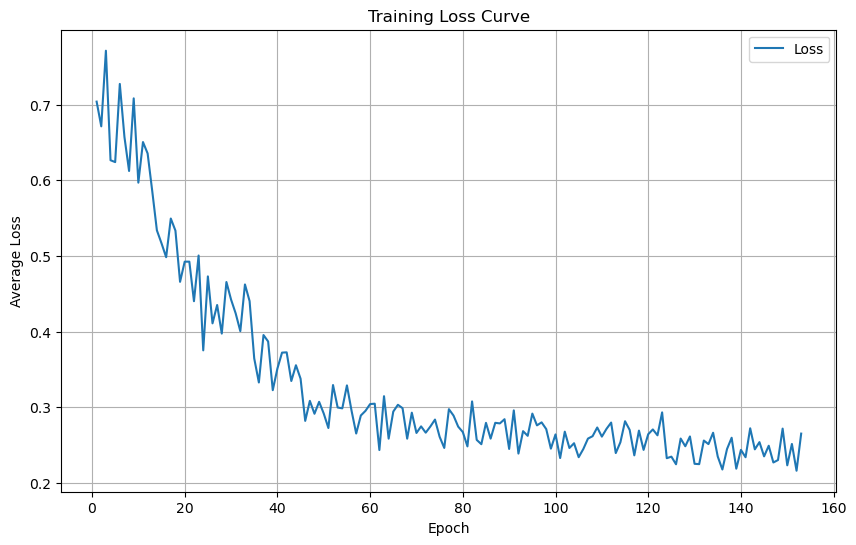

In [31]:
num_epochs = 2000  # Adjust based on your needs
patience = 5
min_delta = 1e-5

previous_loss = float('inf')
epochs_without_improvement = 0
epoch_losses = [] #for plotting loss curve later

try:
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for x_batch, _ in progress_bar:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())

        average_loss = epoch_loss / len(train_dataloader)
        epoch_losses.append(average_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}')

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), f'enh_autoencoder_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1}.')

        # Early stopping checks
        if abs(previous_loss - average_loss) < min_delta:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1}. Loss has not improved significantly.")
                break
        else:
            epochs_without_improvement = 0

        previous_loss = average_loss

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving model...")

# Save the final model after all epochs if training completes normally
torch.save(model.state_dict(), 'enh_autoencoder_final.pth')
print('Final model saved.')

from datetime import datetime
# Plot the loss curve and save it to a file
current_date = datetime.now().strftime('%Y-%m-%d')  # Get the current date as a string
filename = f"loss_curve_{current_date}.png"  # Create the filename

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig(filename)  # Save the plot to a file
print(f"Loss curve saved as {filename}.")


In [14]:
model = EnhancedAutoencoder(in_channels=in_channels)  # Initialize the model
model.load_state_dict(torch.load("enh_autoencoder_final.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


In [15]:
def calculate_reconstruction_error(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    all_inputs = []  # Store all inputs for visualization

    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in dataloader:  # No need for labels
            reconstructed = model(inputs)  # Get reconstructed output
            
            # Calculate the reconstruction error (Mean Squared Error)
            mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])  # Mean over all dimensions
            reconstruction_errors.extend(mse.cpu().numpy())  # Store errors
            
            all_inputs.extend(inputs.cpu().numpy())  # Store original inputs

    return np.array(reconstruction_errors), np.array(all_inputs)  # Return inputs along with errors

# Call the function and get reconstruction errors and original inputs
reconstruction_errors, original_inputs = calculate_reconstruction_error(model, test_dataloader)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 1)  # E.g., 95th percentile, now 1 for testing

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Print some information
print(f"Threshold for anomalies: {threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

KeyError: 0

In [9]:
# Get indices of the detected anomalies
anomaly_indices = np.where(anomalies)[0]

# Determine the unique samples with anomalies
# Assuming each sample corresponds to a certain index in your dataset
# You can also modify this if your dataset has a different structure

# If each sample is a single time-series, use the index directly
# If each sample consists of multiple entries (e.g., 2D or 3D arrays), adjust accordingly
unique_samples_with_anomalies = set(anomaly_indices)

# Count the number of unique samples containing anomalies
num_unique_samples_with_anomalies = len(unique_samples_with_anomalies)

# Print the results
print(f"Number of unique samples containing anomalies: {num_unique_samples_with_anomalies}")

# Optionally, you can list the indices of the samples containing anomalies
print("Indices of samples with anomalies:", unique_samples_with_anomalies)


Number of unique samples containing anomalies: 5
Indices of samples with anomalies: {0, 1, 2, 3, 5}


https://en.wikipedia.org/wiki/Hamming_distance

https://en.wikipedia.org/wiki/Jaccard_index

Jaccard Similarity: Measures the similarity of the anomaly sets by comparing the intersection over the union of the anomalies.
Hamming Distance: Quantifies the difference in anomaly positions between the two samples.
These metrics help you understand how similar or different the anomaly patterns are between two random EEG samples based on your anomaly detection algorithm.

In [10]:
# Introduce synthetic anomalies
# test_dataset.introduce_anomalies(num_anomalies=20)  # Adjust the number as needed

In [11]:
# Function to find two samples that contain anomalies
def find_anomalous_samples(model, dataloader, threshold):
    model.eval()  # Set model to evaluation mode
    anomalous_samples = []
    indices_with_anomalies = set()  # To keep track of unique indices
    
    # Iterate over the dataloader to find samples with anomalies
    for inputs, _ in dataloader:
        with torch.no_grad():
            reconstructed = model(inputs)
        
        # Calculate reconstruction error (Mean Squared Error)
        mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])
        
        # Convert MSE to numpy array and check for anomalies
        errors = mse.cpu().numpy()
        anomalies = errors > threshold
        
        # Append samples if they contain anomalies and are unique
        for idx in range(len(anomalies)):
            if anomalies[idx] and idx not in indices_with_anomalies:
                anomalous_samples.append(inputs[idx])
                indices_with_anomalies.add(idx)  # Track the index to avoid duplicates
            
            # Stop once we have found two unique samples with anomalies
            if len(anomalous_samples) >= 2:
                break
        
        if len(anomalous_samples) >= 2:
            break
    
    if len(anomalous_samples) < 2:
        print("Not enough anomalous samples found in the dataset.")
        return None, None
    
    # Return two unique samples with anomalies
    return anomalous_samples[0], anomalous_samples[1]

# Function to compare two anomalous samples
def compare_anomalous_samples(model, sample_1, sample_2, threshold):
    model.eval()  # Set model to evaluation mode
    
    # Forward pass through the model (no need for gradients)
    with torch.no_grad():
        reconstructed_1 = model(sample_1.unsqueeze(0))  # Add batch dimension
        reconstructed_2 = model(sample_2.unsqueeze(0))  # Add batch dimension
    
    # Calculate reconstruction errors (Mean Squared Error)
    mse_1 = torch.mean((sample_1 - reconstructed_1) ** 2, dim=[1, 2, 3])
    mse_2 = torch.mean((sample_2 - reconstructed_2) ** 2, dim=[1, 2, 3])
    
    # Convert MSE to numpy arrays
    errors_1 = mse_1.cpu().numpy()
    errors_2 = mse_2.cpu().numpy()
    
    # Determine if each sample's reconstruction error is an anomaly
    anomalies_1 = errors_1 > threshold
    anomalies_2 = errors_2 > threshold
    
    # Jaccard similarity (intersection over union)
    jaccard_sim = jaccard_score(anomalies_1, anomalies_2, average='binary')
    
    # Hamming distance (number of different positions)
    hamming_dist = hamming_loss(anomalies_1, anomalies_2)
    
    return jaccard_sim, hamming_dist

# Main logic: find and compare anomalous samples
sample_1, sample_2 = find_anomalous_samples(model, test_dataloader, threshold)

if sample_1 is not None and sample_2 is not None:
    jaccard_similarity, hamming_distance = compare_anomalous_samples(model, sample_1, sample_2, threshold)
    
    print(f"Jaccard Similarity: {jaccard_similarity:.4f}")
    print(f"Hamming Distance: {hamming_distance:.4f}")


Jaccard Similarity: 1.0000
Hamming Distance: 0.0000


A Jaccard similarity of 1.0000 and a Hamming distance of 0.0000 indicates that the two samples are identical in terms of their detected anomalies. This means that both samples have the same anomalies at the same positions.

Next Steps
Here are a few suggestions for what you could do next:

Visualize Anomalous Samples: Consider visualizing both anomalous samples to better understand what the anomalies look like. This can help in diagnosing issues or confirming that the detected anomalies are indeed valid.

Analyze Reconstruction Errors: Investigate the reconstruction errors for different samples, especially those not classified as anomalies. This can give insights into the model's performance.

Experiment with Thresholds: You could experiment with different thresholds for anomaly detection to see how it affects the number of detected anomalies. This can help fine-tune your anomaly detection system.

Add More Evaluation Metrics: Depending on your needs, you might want to compute additional metrics, such as precision, recall, or F1-score, if you have ground truth labels for anomalies.

Test on New Data: If possible, try applying your model to new data to evaluate its generalization performance and see if it effectively identifies anomalies.

Train with More Data: If your dataset is limited, consider gathering more training data or using data augmentation techniques to improve the model's performance.

Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


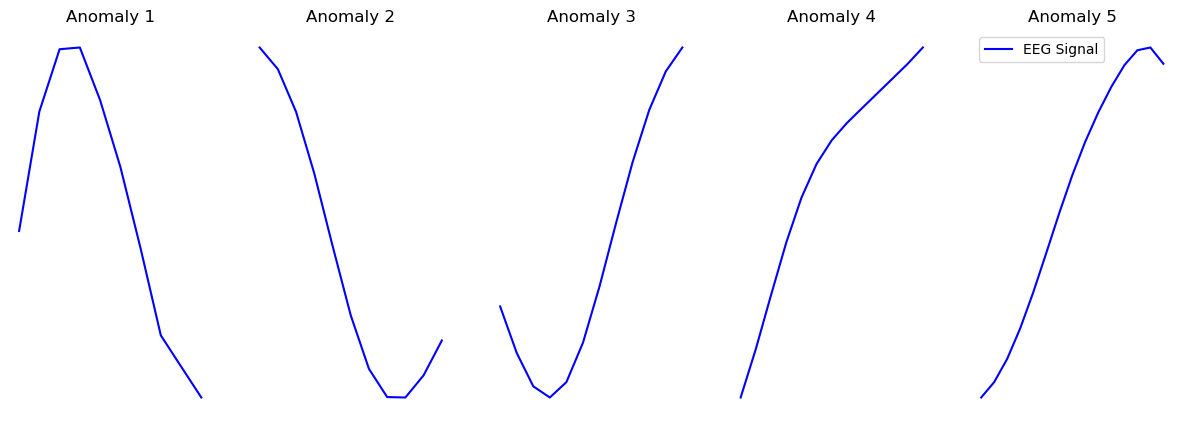

In [12]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 10)  # 100 points before the anomaly
    end = min(anomaly_position + 10, len(image))  # 100 points after the anomaly

    # Adjust the start index if we don't have 100 points before the anomaly
    if anomaly_position < 10:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have 100 points after the anomaly
    if anomaly_position + 10 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after
    
    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        plt.plot(np.arange(anomaly + start, anomaly + start + 1), image_slice[anomaly], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()


Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


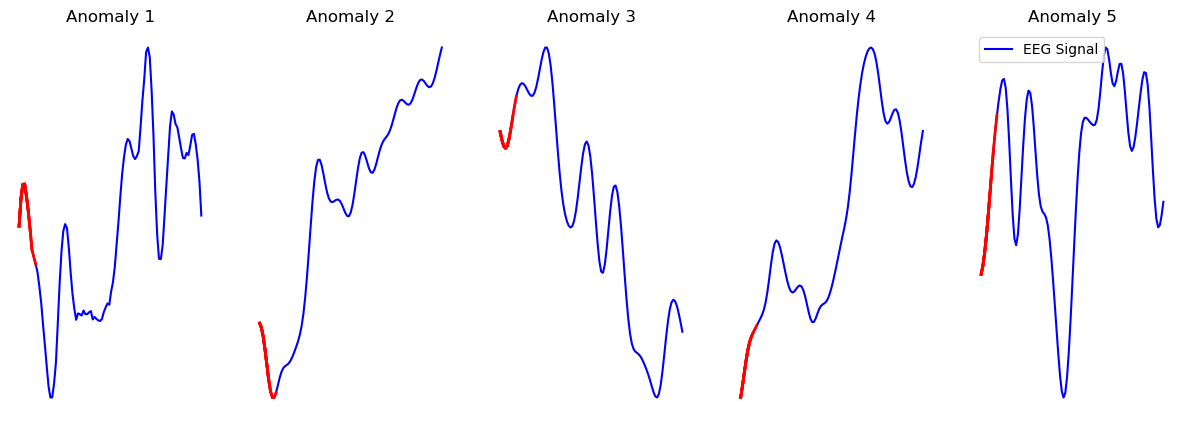

In [23]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 100)  # 10 points before the anomaly
    end = min(anomaly_position + 100, len(image))  # 10 points after the anomaly

    # Adjust the start index if we don't have enough points before the anomaly
    if anomaly_position < 100:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have enough points after the anomaly
    if anomaly_position + 100 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after

    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        # Define the segment for the anomaly
        anomaly_start = max(0, anomaly + start - 5)  # Extend segment start slightly before anomaly
        anomaly_end = min(len(image_slice), anomaly + start + 5)  # Extend segment end slightly after anomaly
        plt.plot(np.arange(anomaly_start, anomaly_end), image[anomaly_start:anomaly_end], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()


1. Prepare the Test Data:
The test set will consist of pairs of recordings:

Positive pairs: Two recordings from the same person (e.g., Artlog1 and Artlog2 for the same person).
Negative pairs: Two recordings from different people (e.g., Artlog1 and Tym1, where Art and Tym are different people).
These pairs are used to test whether the network can correctly classify them as either similar or dissimilar.

2. Define a Function for Similarity Measurement:
After training, the Siamese network will output a similarity score (usually between 0 and 1). You will need to define a threshold for what constitutes a "match" (same person) or "non-match" (different person). Typically, a lower score indicates dissimilarity, and a higher score indicates similarity.

You can use a cosine similarity, Euclidean distance, or contrastive loss output (depending on how you designed the network) to measure this similarity.

For example, if the network outputs a similarity score, a common way to classify the pair is:

Similarity Score ≥ threshold: Same person (positive pair)
Similarity Score < threshold: Different person (negative pair)
3. Evaluate the Network:
The goal is to test how well your network is performing. You’ll calculate metrics such as:

Accuracy: Proportion of correct classifications (positive and negative pairs).
Precision, Recall, and F1-Score: Especially useful when you have imbalanced data (e.g., fewer negative pairs).
ROC Curve and AUC (Area Under Curve): To visualize how well your model can differentiate between similar and dissimilar pairs at different thresholds.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve

def test_siamese_network(model, test_pairs, threshold=0.5):
    """
    Test the Siamese network using the test pairs.
    
    Parameters:
    - model: Trained Siamese network.
    - test_pairs: List of tuples (pair1, pair2, label) where:
        - pair1 and pair2 are the two input data points (e.g., EEG windows),
        - label is 1 for similar (same person) or 0 for dissimilar (different person).
    - threshold: Similarity threshold for deciding positive or negative pair.
    
    Returns:
    - accuracy: The accuracy of the model on the test set.
    - auc: The AUC (Area Under Curve) for the ROC curve.
    """
    
    all_preds = []
    all_labels = []
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for pair1, pair2, label in test_pairs:
            # Get embeddings for both inputs
            output1, output2 = model(pair1, pair2)
            
            # Calculate the distance or similarity score (e.g., Euclidean distance)
            distance = torch.norm(output1 - output2, p=2, dim=1)  # Euclidean distance
            similarity_score = 1 / (1 + distance)  # Convert to similarity score [0, 1]
            
            # Classify the pair based on the similarity score
            pred = (similarity_score >= threshold).float()  # 1 for similar, 0 for dissimilar
            
            # Append the predicted and true labels
            all_preds.append(pred.item())
            all_labels.append(label)
    
    # Calculate accuracy, precision, recall, and AUC
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    
    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return accuracy, auc, precision, recall

# Example usage:
test_pairs = [
    # (pair1, pair2, label)
    (pair1_data, pair2_data, 1),  # 1 means same person (positive pair)
    (pair1_data, pair3_data, 0),  # 0 means different person (negative pair)
    # Add more test pairs...
]

accuracy, auc, precision, recall = test_siamese_network(model, test_pairs)


Accuracy: Shows the proportion of correctly classified pairs. However, if your test set is imbalanced (e.g., more positive pairs than negative), accuracy may not be a good indicator of model performance.

AUC (Area Under ROC Curve): Measures the ability of the model to discriminate between positive and negative pairs at various thresholds. A higher AUC indicates better performance.

Precision-Recall Curve: Useful when dealing with imbalanced datasets, as it shows how well the model performs with respect to both positive and negative classes.

In [ ]:
def aggregate_window_comparisons(window_pairs, threshold=0.5):
    """
    Aggregate results from multiple window comparisons.
    
    Parameters:
    - window_pairs: List of tuples (window1, window2, label) where:
        - window1 and window2 are EEG windows,
        - label is 1 for same person or 0 for different person.
    - threshold: Similarity threshold for classifying the pair.
    
    Returns:
    - final_pred: Aggregated prediction (1 for same person, 0 for different person).
    """
    similarities = []
    
    for window1, window2, label in window_pairs:
        similarity_score = compare_two_windows(window1, window2)
        similarities.append(similarity_score)
    
    # Average similarity score across all windows
    average_similarity = np.mean(similarities)
    
    # Classify based on average similarity score
    final_pred = 1 if average_similarity >= threshold else 0
    return final_pred

def compare_two_windows(window1, window2):
    # Compare two windows and return similarity score
    # This could be using Euclidean distance, cosine similarity, etc.
    distance = np.linalg.norm(window1 - window2)
    similarity_score = 1 / (1 + distance)
    return similarity_score